In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import glob
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
from trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done






In [2]:
# stim_path = "data/LargeRandLIF2/LargeRandNet2_PoissonRate.csv"
# response_path = "data/LargeRandLIF2/LargeRandNet2_SpikeTime.csv"

# if not os.path.exists(response_path):
#     print("Downloading data...")
#     import gdown
#     url = "https://drive.google.com/drive/folders/1dkU4GjyKt5ror5DuyfM135ISsnE69Jp5?usp=sharing"
#     gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")

stim_path = "data/LargeRandLIF2-2/LargeRandNet2_PoissonRate.csv"
response_path = "data/LargeRandLIF2-2/LargeRandNet2_SpikeTime.csv"

if not os.path.exists(response_path):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/1yDWde9rJ_9nOYN5Ic-_JoAYaW2a2jYOY?usp=sharing"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")


# Load Data
stimulus = np.transpose(np.loadtxt(stim_path, delimiter=','), (1, 0))
df = pd.read_csv(response_path, names=['Time', 'ID'])
dt_res = 10000
df['Time'] = df['Time'].round(4)
df['Trial'] = df['Time'].apply(lambda x: x // dt_res + 1).astype(int)
df['Time'] = df['Time'].apply(lambda x: x - ((x // dt_res) * dt_res)).round(2)
df['ID'] = df['ID'].astype(int)

In [ ]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)



In [ ]:
from utils import set_seed
n_seed = 25
set_seed(n_seed)

In [ ]:
stimulus.shape


(10000, 500)

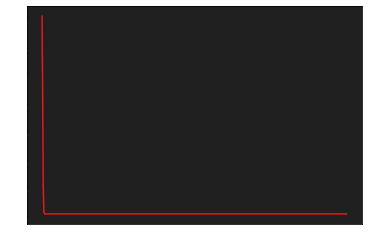

In [ ]:
plt.plot(stimulus[0, :,])



In [ ]:
stimulus.shape


(10000, 500)

In [ ]:
df


,Time,ID,Trial
0,4.6,50,1
1,4.7,112,1
2,5.0,460,1
3,5.1,206,1
4,5.2,645,1
...,...,...,...
6016789,9997.1,787,100
6016790,9997.2,494,100
6016791,9998.3,254,100
6016792,9998.9,786,100


In [ ]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
frame_window = 20
window = 1
window_prev = 20 - window
dt = 0.1
dt_frames = 20
start_interval = max(window, window_prev)
p_window = window / (window + window_prev)

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']

In [ ]:
# from utils import df_to_dict

# dict_path = "data/LargeRandLIF2-2/LargeRandNet2_SpikeTime_dict.pkl"

# if not os.path.exists(dict_path):
#     print("Creating dictionary...")
#     df_dict = df_to_dict(df)
#     with open(dict_path, 'wb') as f:
#         pickle.dump(df_dict, f)
# else:
#     print("Loading dictionary...")
#     with open(dict_path, 'rb') as f:
#         df_dict = pickle.load(f)

# int_trials = df.groupby(['Interval', 'Trial']).size()
# print(int_trials.mean())
# # df.groupby(['Interval', 'Trial']).agg(['nunique'])
# var_group = 'Interval'
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# # df.groupby(['Interval_2', 'Trial']).size().mean()

# var_group = 'Interval_2'
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# # df.groupby(['Interval_2', 'Trial']).size().mean()

# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()

# n_unique = len(int_trials)
# int_trials.nlargest(int(0.2 * n_unique))


In [ ]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_embd = 256
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
frame_block_size = 500  # math.ceil(frame_feats.shape[-1] * frame_window)
n_embd_frames = 10000

prev_id_block_size = 800 # math.ceil(frame_block_size * (1 - p_window))
id_block_size = 150    # math.ceil(frame_block_size * p_window)
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }


In [12]:
r_split = 0.8
train_trials = sorted(df['Trial'].unique())[:int(len(df['Trial'].unique()) * r_split)]
train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]


In [13]:
from SpikeVidUtils import SpikeTimeVidData2

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                  dt_frames=dt_frames, dataset='LIF2')
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                  dt_frames=dt_frames, dataset='LIF2')

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')


Length: 4819760 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 500, id: 150
Length: 1197034 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 500, id: 150
train: 780973, test: 195214


In [14]:
# from utils import get_class_weights
# class_weights = get_class_weights(train_dataset, stoi, stoi_dt)



In [15]:
from model_neuroformer_LRN import GPT, GPTConfig, neuralGPTConfig
# initialize config class and model (holds hyperparameters)
# for is_conv in [True, False]:    
conv_layer = False
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                    id_vocab_size=train_dataset.id_population_size,
                    frame_block_size=frame_block_size,
                    id_block_size=id_block_size,  # frame_block_size
                    prev_id_block_size=prev_id_block_size,
                    sparse_mask=False, p_sparse=0.25, sparse_topk_frame=None, sparse_topk_id=None,
                    n_dt=len(n_dt),
                    data_size=train_dataset.size,
                    class_weights=None,
                    pretrain=False,
                    n_state_layers=6, n_state_history_layers=4, n_stimulus_layers=4, self_att_layers=8,
                    n_layer=10, n_head=8, n_embd=n_embd, n_embd_frames=n_embd_frames,
                    contrastive=False, clip_emb=1024, clip_temp=0.5,
                    temp_emb=True, pos_emb=False,
                    id_drop=0.2, im_drop=0.2,
                    window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                    neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, dataset='LIF2',
                    ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35
model = GPT(mconf)


02/15/2023 16:32:43 - INFO - model_neuroformer_LRN -   number of parameters: 2.230894e+08


In [ ]:
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 500
batch_size = (32 * 8)
shuffle = True

weighted = True if mconf.class_weights is not None else False
title =  f'window:{window}_prev:{window_prev}'
model_path = f"""./models/tensorboard/LRL2/ignore_index/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

# if os.path.exists(model_path):
#     model.load_state_dict(torch.load(model_path))
#     print(f"-- loaded model from {model_path} --")

model.load_state_dict(torch.load("/data5/antonis/neuroformer/models/tensorboard/LRL2/ignore_index/window:1_prev:19/sparse_f:None_id:None/w:1_wp:19/6_Cont:False_window:1_f_window:20_df:0.1_blocksize:150_conv_False_shuffle:True_batch:256_sparse_(None_None)_blocksz1450_pos_emb:False_temp_emb:True_drop:0.2_dt:True_2.0_191_max0.1_(6, 4, 4)_8_256.pt"))

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=False, patience=3, warmup_tokens=8e0, 
                    decay_weights=True, weight_decay=0.1, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, dist=False,
                    save_every=1000)

trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
# trainer.train()


In [ ]:
loader = DataLoader(train_dataset, shuffle=False, pin_memory=False)
iterable = iter(loader)



In [ ]:
x, y = next(iterable)
model.cpu()
features, logits, loss = model(x, y)


In [ ]:
"""

RUN SIMULATION

"""


from utils import *
from IPython.utils import io
# top_p=0.25, top_p_t=0.9, temp=2.


# model.load_state_dict(torch.load(model_path, map_location='cpu'))

# trials = np.random.choice(train_data['Trial'].unique(), size=12)
trials = test_data['Trial'].unique()[:4]
results_dict = dict()
# for n in range(2, 20):
df_pred = None
df_true = None
n_p = 0.3   # (n + 1) * 0.05
temp = 2
# stoi['SOS'] = 2000



In [ ]:
end_interval = window * 500

for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() as captured:
        print(f"Trial: {trial}")
        df_trial = df[(df['Trial'] == trial) & (df['Time'] < end_interval)]
        trial_dataset = SpikeTimeVidData2(df_trial, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                  dt_frames=dt_frames, dataset='LIF2')
        trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                           sample=True, top_p=0.95, top_p_t=0.95, temp=1.0, temp_t=1., frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])

# df_preds[n] = df_pred
# print(f"--- n: {n}, n_p: {n_p}, temp: {temp} ---")
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )
# results_dict[n] = (scores)



In [ ]:
df


In [ ]:
df_1 = df[df['Trial'].isin(trials)]
df_2 = df[df['Trial'].isin(trials + 1)]
df_3 = df[df['Trial'].isin(trials + 2)]


In [ ]:
df_pred_full = df_pred
window_pred = 5

df_list = [df_pred_full, df_1, df_2, df_3]

for df_ in df_list:
    df_['Interval'] = make_intervals(df_, window_pred)
    df_ = df_[df_['Interval'] > window_prev + window]
    df_ = df_[df_['Interval'] < 2 * window]


window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))


# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)



In [ ]:

"""

Evaluate results

"""

from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)
plt.show()

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)
plt.savefig(os.path.join(dir_name, F'psth_corr_{title}.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{title}.csv'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_{title}.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

print(f"model: {title}")





In [ ]:
loader = DataLoader(train_dataset, batch_size=5, shuffle=False, pin_memory=False)
iterable = iter(train_dataset)


In [ ]:
x, y = next(iterable)
x['id'], x['interval'], x['trial']


T = len(x['id'])
P = x['pad']
T_prev = len(x['id_prev'])
P_prev = x['pad_prev']

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(x['frames'].shape)

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0.2
t_var = 'Time' # 'Interval'
int_var = 'pid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]




In [16]:
loader = DataLoader(train_dataset, batch_size=5, shuffle=False, pin_memory=False)
iterable = iter(train_dataset)

In [17]:
loader = DataLoader(train_dataset, batch_size=5, shuffle=False, pin_memory=False)
iterable = iter(train_dataset)
x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0.1
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

t_var = 'Time' # 'Interval'
int_var = 'pid'
df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]

iv: 20.0, ix+window: 21.0 pid: tensor([ 1., 20.]) cid: tensor([20., 21.])
x: ['SOS', 117, 297, 418, 569, 151, 156, 588, 701, 33, 41, 343, 845, 643, 138, 560, 656, 170, 341, 'EOS']
xid_prev: ['SOS', 50, 112, 460, 206, 645, 350, 488, 544, 334, 348, 623, 830, 892, 85, 151, 43, 263, 878, 778, 836, 50, 777, 147, 999, 867, 206, 623, 43, 544, 950, 151, 124, 347, 560, 252, 460, 625, 580, 334, 248, 796, 114, 72, 273, 564, 674, 350, 488, 85, 276, 542, 469, 800, 878, 970, 43, 201, 724, 348, 464, 642, 21, 460, 151, 777, 836, 948, 120, 163, 701, 263, 741, 75, 175, 713, 15, 79, 317, 493, 112, 662, 335, 449, 305, 366, 856, 884, 72, 581, 922, 65, 252, 18, 197, 56, 57, 518, 319, 462, 940, 983, 408, 454, 745, 92, 224, 509, 840, 999, 242, 488, 883, 262, 564, 354, 639, 114, 379, 674, 113, 349, 987, 188, 724, 216, 874, 76, 315, 460, 2, 593, 796, 149, 326, 712, 229, 334, 590, 680, 783, 942, 944, 477, 102, 982, 799, 59, 120, 474, 508, 820, 880, 305, 794, 124, 798, 884, 382, 675, 741, 891, 112, 501, 245, 714,

,Time,ID,Trial,Interval,Interval_2
0,4.6,50,1,5.0,19.0
1,4.7,112,1,5.0,19.0
2,5.0,460,1,5.0,19.0
3,5.1,206,1,6.0,19.0
4,5.2,645,1,6.0,19.0
...,...,...,...,...,...
165,19.9,358,1,20.0,38.0
166,20.0,79,1,20.0,38.0
167,20.0,413,1,20.0,38.0
168,20.0,690,1,20.0,38.0


In [18]:
x['frames'].shape

torch.Size([10000, 1])

In [19]:
stimulus.shape

(10000, 500)